# Figure 1: Diurnal Cycle of Precipitation in the Central US
* SP-E3SM vs. E3SM at ne120 and ne30 resolution

In [71]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs   # map plots
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from glob import glob

In [11]:
# select region from SE grid based on lat/lon range
# region follows Feng etal 2016, Nature Comm
central_us = {'lat': slice(31, 49), 'lon': slice(256, 279)}
central_us180 = {'lat': slice(31, 49), 'lon': slice(256-360, 279-360)}
prect_diurnal = {}

In [77]:
ds_obs = xr.open_dataset('/global/project/projectdirs/m3312/jlee1046/post_process/diurnal_cycle_precip_GPM/3B-HHR.MS.MRG.3IMERG.precipitationCal.DIUR.YR2014-YR2018.JJA.remap.nc')
ds_obs_mam = xr.open_dataset('/global/cscratch1/sd/crjones/obs/gpm/gpm-MAM-diurnal.nc')

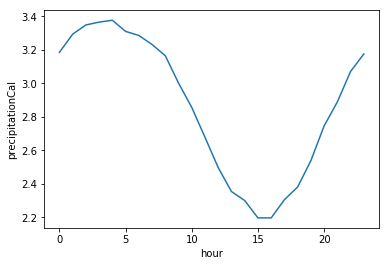

In [9]:
(24 * ds_obs_mam['precipitationCal'].sel(**central_us180).mean(dim=['lat', 'lon', 'year'])).plot()

In [6]:
ds_obs_mam

<xarray.Dataset>
Dimensions:           (hour: 24, lat: 351, lon: 792, year: 3)
Coordinates:
  * lat               (lat) float32 20.95 21.05 21.15 ... 55.75 55.85 55.95
  * lon               (lon) float32 -132.05 -131.95 -131.85 ... -53.05 -52.95
  * hour              (hour) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * year              (year) object '2014' '2015' '2018'
Data variables:
    precipitationCal  (year, hour, lon, lat) float32 0.0008116326 ... 0.06587612

In [15]:
ds_obs

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, nbnd: 2, time: 48)
Coordinates:
  * lat               (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float64 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time              (time) object 2014-06-01 00:00:00 ... 2014-06-01 23:30:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds          (lat, nbnd) float64 ...
    lon_bnds          (lon, nbnd) float64 ...
    gw                (lat) float64 ...
    area              (lat, lon) float64 ...
    precipitationCal  (time, lat, lon) float32 nan nan ... 0.0025703043
Attributes:
    creation_date:             Wed Jun 12 08:09:59 PDT 2019
    Conventions:               None
    title:                     GPM: HDF5 to netCDF: Composite diurnal cycle o...
    history:                   Wed Jun 12 09:23:20 2019: ncks -O -t 2 --no_tm...
    remap_script:              ncremap
    remap_command:             '/global/homes/z/zender/bin_co

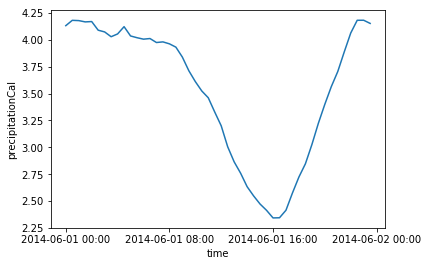

In [13]:
(24 * ds_obs['precipitationCal']).sel(**central_us).mean(dim=['lat', 'lon']).plot()

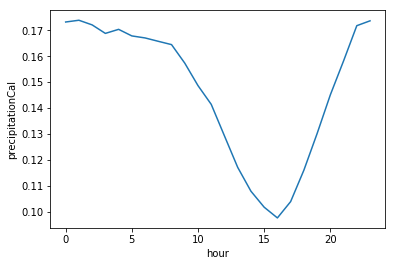

In [14]:
ds_obs['precipitationCal'].sel(**central_us).groupby('time.hour').mean(dim=['lat', 'lon', 'time']).plot()

In [7]:
def prep_diurnal_cycle_v2(da):
    da_dict = {key: val for key, val in da.groupby('time.season') if key in ['MAM', 'JJA']}
    da_diurnal = {key: val.mean(dim=['lat','lon']).groupby('time.hour').mean(dim='time') for key, val in da_dict.items()}
    return xr.concat([da_diurnal['MAM'].load(), da_diurnal['JJA'].load()], 
                     dim=pd.Index(('MAM', 'JJA'), name='season'))

In [16]:
def prep_diurnal_cycle(da):
    da_dict = {key: val for key, val in da.groupby('time.season') if key in ['MAM', 'JJA']}
    da_diurnal = {key: val.groupby('time.hour').mean(dim='time') for key, val in da_dict.items()}
    return xr.concat([da_diurnal['MAM'].load(), da_diurnal['JJA'].load()], 
                     dim=pd.Index(('MAM', 'JJA'), name='season'))

In [17]:
# Lo-res E3SM
ds_ne30 = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/earlyscience.FC5AV1C-L.ne30.E3SM.20190519/remap/*.CONUS.nc')
prect = ds_ne30['PRECT'].sel(**central_us)
prect_diurnal['E3SM_ne30'] = prep_diurnal_cycle(prect)

In [18]:
# Lo-res SP-E3SM
ds_sp_ne30 = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/earlyscience.FC5AV1C-L.ne30.sp1_64x1_1000m.20190415/hourly_2d_hist/remap/*.CONUS.nc')
prect = ds_sp_ne30['PRECT'].sel(**central_us)
prect_diurnal['SP_ne30'] = prep_diurnal_cycle(prect)

In [19]:
# Hi-res SP-E3SM
ds_sp_ne120 = xr.open_mfdataset('/global/cscratch1/sd/crjones/for_zhe_feng/e3sm-mmf/*.200?-0[3-8]*.CONUS.nc')
prect = ds_sp_ne120['PRECT'].sel(**central_us)
prect_diurnal['SP_ne120'] = prep_diurnal_cycle(prect)

In [20]:
# Hi-res E3SM
ds_ne120 = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science_e3sm/hourly_2d_hist/remap/daily/*.000?-0[3-8]*.CONUS.nc')
prect = ds_ne120['PRECT'].sel(**central_us)
prect_diurnal['E3SM_ne120'] = prep_diurnal_cycle(prect)

In [8]:
prect_diurnal_orig = prect_diurnal.copy()

In [27]:
local_time = np.arange(-12, 12)

In [24]:
local_time

array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11])

In [30]:
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
prect_diurnal = prect_diurnal_orig.copy()
utc_offset = -6
for key, da in prect_diurnal.items():
    dat = da.values  # numpy array, shape = (local_time, lon)
    dat = np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
    print(dat.shape)
    # local_time = da.hour - 12  # hour from -12 to 24 (aka 0) to 12
    prect_diurnal[key] = da.assign_coords(hour=local_time)

(2, 24, 18, 23)
(2, 24, 18, 23)
(2, 24, 72, 92)
(2, 24, 72, 92)


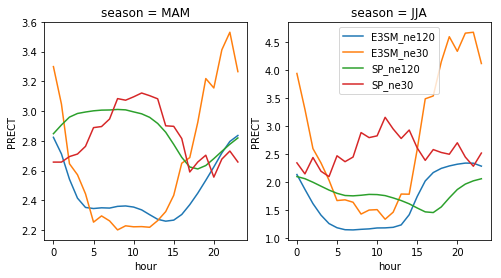

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
models = sorted([key for key in prect_diurnal.keys()])
seasons = ['MAM', 'JJA']
for ax, season in zip(axes, seasons):
    for key in models:
        # p = (prect_diurnal[key].sel(season=season).mean(dim=['lat', 'lon']) * 86400 * 1000).plot(ax=ax, x='hour', label=key)
        p = (prect_diurnal[key].sel(season=season) * 86400 * 1000).plot(ax=ax, x='hour', label=key)
ax.legend()

In [24]:
prect_diurnal[key]

<xarray.DataArray 'PRECT' (season: 2, hour: 24, lat: 72, lon: 92)>
array([[[[2.144546e-08, ..., 4.951160e-08],
         ...,
         [1.499033e-08, ..., 2.854885e-08]],

        ...,

        [[2.389227e-08, ..., 4.748654e-08],
         ...,
         [1.833825e-08, ..., 2.900898e-08]]],


       [[[2.462770e-08, ..., 3.549468e-08],
         ...,
         [1.729633e-08, ..., 3.156148e-08]],

        ...,

        [[2.539511e-08, ..., 4.001247e-08],
         ...,
         [1.543498e-08, ..., 3.140787e-08]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
  * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * season   (season) object 'MAM' 'JJA'

In [35]:
models

['E3SM_ne120', 'E3SM_ne30', 'SP_ne120', 'SP_ne30']

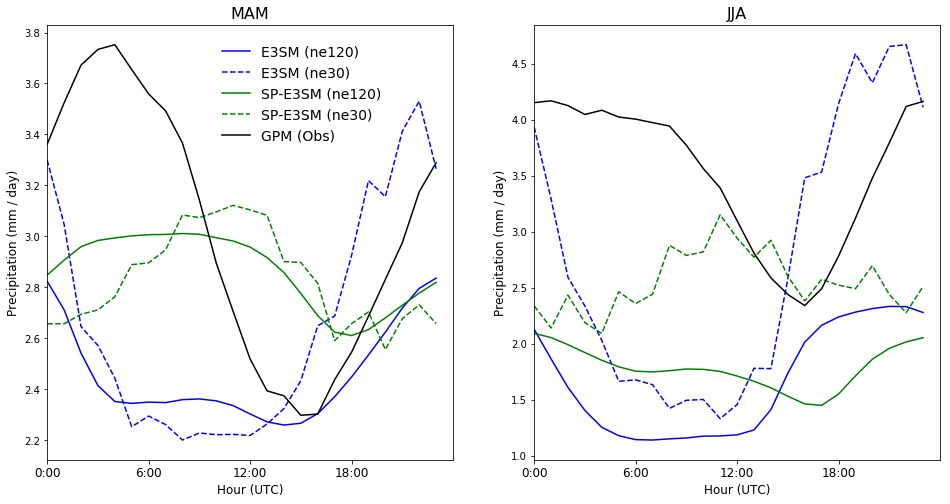

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
models = sorted([key for key in prect_diurnal.keys()])
model_labels = ['E3SM (ne120)', 'E3SM (ne30)', 'SP-E3SM (ne120)', 'SP-E3SM (ne30)', 'GPM (Obs)']
colors = ['blue', 'blue', 'green', 'green', 'black']
styles = ['-', '--', '-', '--', '-']
seasons = ['MAM', 'JJA']
for ax, season in zip(axes, seasons):
    for i, key in enumerate(models):
        # p = (prect_diurnal[key].sel(season=season).mean(dim=['lat', 'lon']) * 86400 * 1000).plot(ax=ax, x='hour', label=key)
        p = (prect_diurnal[key].sel(season=season).mean(dim=['lat', 'lon']) * 86400 * 1000).plot(ax=ax, x='hour',
                                                                                                 label=model_labels[i],
                                                                                                 color=colors[i],
                                                                                                 linestyle=styles[i])
    if season == 'JJA':
        da = 24 * ds_obs['precipitationCal'].sel(**central_us).groupby('time.hour').mean(dim=['time', 'lat', 'lon'])
    elif season == 'MAM':
        da = 24 * ds_obs_mam['precipitationCal'].sel(**central_us180).mean(dim=['lat', 'lon', 'year'])
    da.plot(ax=ax, x='hour', label=model_labels[-1],
            color=colors[-1],
            linestyle=styles[-1])
    ax.set_title(season, fontsize=16)
    ax.set_ylabel('Precipitation (mm / day)', fontsize=12)
    ax.set_xlabel('Hour (UTC)', fontsize=12)
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    # ax.set_ylim([1.0, 4.75])
axes[0].legend(fontsize=14, frameon=False, bbox_to_anchor=(0.4, 0.7))
plt.savefig('central_us_diurnal_cycle.svg', bbox_inches='tight')
plt.savefig('central_us_diurnal_cycle.png', bbox_inches='tight', dpi=1200)

In [15]:
da

<xarray.DataArray 'PRECT' (season: 2, hour: 24, lat: 72, lon: 92)>
array([[[[2.144546e-08, ..., 4.951160e-08],
         ...,
         [1.499033e-08, ..., 2.854885e-08]],

        ...,

        [[2.389227e-08, ..., 4.748654e-08],
         ...,
         [1.833825e-08, ..., 2.900898e-08]]],


       [[[2.462770e-08, ..., 3.549468e-08],
         ...,
         [1.729633e-08, ..., 3.156148e-08]],

        ...,

        [[2.539511e-08, ..., 4.001247e-08],
         ...,
         [1.543498e-08, ..., 3.140787e-08]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
  * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * season   (season) object 'MAM' 'JJA'

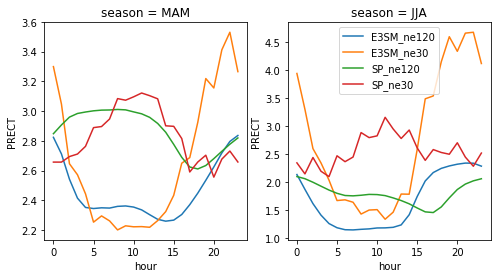

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
models = sorted([key for key in prect_diurnal.keys()])
seasons = ['MAM', 'JJA']
for ax, season in zip(axes, seasons):
    for key in models:
        p = (prect_diurnal[key].sel(season=season).mean(dim=['lat', 'lon']) * 86400 * 1000).plot(ax=ax, x='hour', label=key)
ax.legend()
#for key, da in prect_diurnal.items():
#    plt.figure()
#    p = (da.mean(dim=['lat', 'lon']) * 86400 * 1000).plot.line(x='hour')
#    plt.gca().set_title(key)
#    plt.gca().set_ylim([0, 5])

In [4]:
ds_e3sm_hr = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science_e3sm/hourly_2d_hist/remap/*.h1.000?-0[2-8]-??.nc',
                               preprocess=preprocess, parallel=True)

KeyboardInterrupt: 

In [11]:
prect = ds_ne30['PRECT'].sel(**central_us)
prect_diurnal = prep_diurnal_cycle(prect)

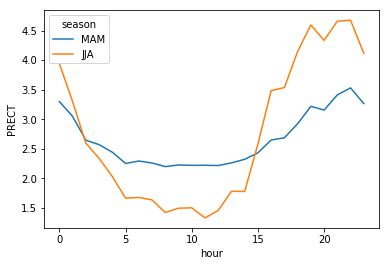

In [14]:
(prect_diurnal.mean(dim=['lat', 'lon']) * 86400 * 1000).plot.line(x='hour')

In [4]:
prect = ds_e3sm_hr['PRECT'].sel(**central_us)

In [8]:
prect_dict = {key: val for key, val in prect.groupby('time.season') if key in ['MAM', 'JJA']}
# diurnal cycle

In [11]:
prect_diurnal = {key: da.groupby('time.hour').mean(dim='time') for key, da in prect_dict.items()}

In [14]:
prect_central_ts = {key: da.mean(dim=['lat', 'lon']).load() for key, da in prect_diurnal.items()}
prect_central_ts

{'JJA': <xarray.DataArray 'PRECT' (hour: 24)>
 array([2.467287e-08, 2.160746e-08, 1.865901e-08, 1.628378e-08, 1.453696e-08,
        1.367463e-08, 1.326680e-08, 1.322416e-08, 1.334686e-08, 1.343847e-08,
        1.362775e-08, 1.364729e-08, 1.376109e-08, 1.426155e-08, 1.636272e-08,
        2.013675e-08, 2.334665e-08, 2.508582e-08, 2.594887e-08, 2.644864e-08,
        2.681182e-08, 2.704050e-08, 2.701859e-08, 2.640920e-08], dtype=float32)
 Coordinates:
   * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23,
 'MAM': <xarray.DataArray 'PRECT' (hour: 24)>
 array([3.268189e-08, 3.138845e-08, 2.941987e-08, 2.794526e-08, 2.722182e-08,
        2.713773e-08, 2.719388e-08, 2.717270e-08, 2.730628e-08, 2.733812e-08,
        2.725155e-08, 2.703253e-08, 2.665769e-08, 2.629734e-08, 2.615317e-08,
        2.623459e-08, 2.667255e-08, 2.743844e-08, 2.833489e-08, 2.933676e-08,
        3.037459e-08, 3.146506e-08, 3.236046e-08, 3.282649e-08], dtype=float32)
 Coordinates:
   * hour     

In [16]:
prect_central_da = xr.concat([prect_central_ts['MAM'] * 86400 * 1000, prect_central_ts['JJA'] * 86400 * 1000],
                             dim=pd.Index(('MAM', 'JJA'), name='season'))

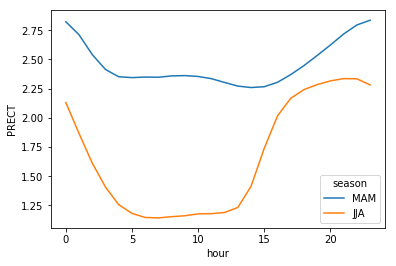

In [21]:
prect_central_da.plot.line(x='hour')

In [12]:
prect_diurnal

{'JJA': <xarray.DataArray 'PRECT' (hour: 24, lat: 72, lon: 92)>
 dask.array<shape=(24, 72, 92), dtype=float32, chunksize=(1, 72, 92)>
 Coordinates:
   * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
   * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
   * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23,
 'MAM': <xarray.DataArray 'PRECT' (hour: 24, lat: 72, lon: 92)>
 dask.array<shape=(24, 72, 92), dtype=float32, chunksize=(1, 72, 92)>
 Coordinates:
   * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
   * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
   * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23}

In [9]:
prect_dict

{'JJA': <xarray.DataArray 'PRECT' (time: 6624, lat: 72, lon: 92)>
 dask.array<shape=(6624, 72, 92), dtype=float32, chunksize=(96, 72, 92)>
 Coordinates:
   * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
   * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
   * time     (time) object 0001-06-01 00:00:00 ... 0003-08-31 23:00:00
 Attributes:
     units:          m/s
     long_name:      Total (convective and large-scale) precipitation rate (li...
     cell_methods:   time: mean
     cell_measures:  area: area,
 'MAM': <xarray.DataArray 'PRECT' (time: 6624, lat: 72, lon: 92)>
 dask.array<shape=(6624, 72, 92), dtype=float32, chunksize=(24, 72, 92)>
 Coordinates:
   * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
   * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
   * time     (time) object 0001-03-01 00:00:00 ... 0003-05-31 23:00:00
 Attributes:
     units:          m/s
     lo

In [7]:
for key, val in prect.groupby('time.season'):
    print(key)
    print(val)

DJF
<xarray.DataArray 'PRECT' (time: 6480, lat: 72, lon: 92)>
dask.array<shape=(6480, 72, 92), dtype=float32, chunksize=(120, 72, 92)>
Coordinates:
  * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
  * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
  * time     (time) object 0001-01-01 00:00:00 ... 0003-12-31 22:59:59
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area
JJA
<xarray.DataArray 'PRECT' (time: 6624, lat: 72, lon: 92)>
dask.array<shape=(6624, 72, 92), dtype=float32, chunksize=(96, 72, 92)>
Coordinates:
  * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 48.12 48.38 48.62 48.88
  * lon      (lon) float64 256.1 256.4 256.6 256.9 ... 278.1 278.4 278.6 278.9
  * time     (time) object 0001-06-01 00:00:00 ... 0003-08-31 23:00:00
Attributes:
    units:          m/s
    long_name:      Total (conve

# Spatial distribution of precipitation

In [54]:
ds_obs

<xarray.Dataset>
Dimensions:                      (lat: 105, lon: 161, time: 78)
Coordinates:
  * lon                          (lon) float32 -110.0 -109.75 ... -70.25 -70.0
  * lat                          (lat) float32 25.0 25.25 25.5 ... 50.75 51.0
  * time                         (time) datetime64[ns] 2004-03-01 ... 2016-08-01
Data variables:
    precipitation                (time, lat, lon) float32 dask.array<shape=(78, 105, 161), chunksize=(1, 105, 161)>
    mcs_precipitation_ctl        (time, lat, lon) float32 dask.array<shape=(78, 105, 161), chunksize=(1, 105, 161)>
    mcs_precipitation_exp        (time, lat, lon) float32 dask.array<shape=(78, 105, 161), chunksize=(1, 105, 161)>
    mcs_precipitation_count_ctl  (time, lat, lon) float32 dask.array<shape=(78, 105, 161), chunksize=(1, 105, 161)>
    mcs_precipitation_count_exp  (time, lat, lon) float32 dask.array<shape=(78, 105, 161), chunksize=(1, 105, 161)>
    mcs_number_ctl               (time, lat, lon) float32 dask.array<sha

In [57]:
ds_obs.time

<xarray.DataArray 'time' (time: 78)>
array(['2004-03-01T00:00:00.000000000', '2004-04-01T00:00:00.000000000',
       '2004-05-01T00:00:00.000000000', '2004-06-01T00:00:00.000000000',
       '2004-07-01T00:00:00.000000000', '2004-08-01T00:00:00.000000000',
       '2005-03-01T00:00:00.000000000', '2005-04-01T00:00:00.000000000',
       '2005-05-01T00:00:00.000000000', '2005-06-01T00:00:00.000000000',
       '2005-07-01T00:00:00.000000000', '2005-08-01T00:00:00.000000000',
       '2006-03-01T00:00:00.000000000', '2006-04-01T00:00:00.000000000',
       '2006-05-01T00:00:00.000000000', '2006-06-01T00:00:00.000000000',
       '2006-07-01T00:00:00.000000000', '2006-08-01T00:00:00.000000000',
       '2007-03-01T00:00:00.000000000', '2007-04-01T00:00:00.000000000',
       '2007-05-01T00:00:00.000000000', '2007-06-01T00:00:00.000000000',
       '2007-07-01T00:00:00.000000000', '2007-08-01T00:00:00.000000000',
       '2008-03-01T00:00:00.000000000', '2008-04-01T00:00:00.000000000',
       '2008-0

In [45]:
ds_obs = xr.open_mfdataset('/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/monthly/mcs_rainmap_20??0[3-8]*.nc')

In [55]:
precip_obs = (ds_obs['precipitation'].groupby('time.season').sum(dim='time') / (91 * 13)).load()

In [ ]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

def plot_precip_map(prect_obs, e3sm_ne30, e3sm_ne120, sp_ne30, sp_ne120,
                    season='JJA', figsize=(12, 8), **kwargs):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize,
                             subplot_kw={'projection': ccrs.PlateCarree()})
    rescale = 86400 * 1000
    ax_titles = ['E3SM (ne30)', 'E3SM (ne120)', 'SP-E3SM (ne30)', 'SP-E3SM (ne120)']
    for ax, da0 in zip(axes.flat, [e3sm_ne30, e3sm_ne120, sp_ne30, sp_ne120]):
        da = da0 * rescale
        da.attrs['units'] = 'mm / day'
        units = 'mm d$^{-1}$'
        da.sel(season=season).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
                                   cmap=plt.cm.YlGnBu, robust=True, **kwargs)
    # levels = np.arange(0, 1.3, 0.1)
    # p = da.plot(x='lon', y='lat', col='model', row='season', figsize=(12, 12),
    #             subplot_kws={'projection': ccrs.PlateCarree()}, 
    #             transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu,    # cmap=cmap_prect,
    #             # levels=levels,
    #             robust=True, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50, 
    #                                       'label': 'MCS Precipitation (mm / day)'})
    # ax_titles = ['E3SM-MMF', 'E3SMv1']
    for i, ax in enumerate(axes.flat):
        ax.set_extent([250 - 360, 285 - 360, 28, 49])
        ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
        ax.coastlines()
        # format gridlines
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
        ax.add_feature(cfeature.LAND)
        ax.set_title(ax_titles[i])
    fig.suptitle(season)

In [68]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

def plot_precip_map(prect_obs, e3sm_ne30, e3sm_ne120, sp_ne30, sp_ne120, fig_kws={'dpi': 1200, 'figsize': (12, 8)},
                    season='JJA', **kwargs):
    fig = plt.figure(**fig_kws)
    # gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.05])
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.05], )
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
    ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    ax5 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
    # ax_cb = fig.add_subplot(gs[2,:])
    ax_cb = fig.add_subplot(gs[:,-1])

    ax_titles = ['Obs', 'E3SM (ne30)', 'E3SM (ne120)', 'SP-E3SM (ne30)', 'SP-E3SM (ne120)']
    for i, (ax, da) in enumerate(zip([ax1, ax2, ax3, ax4, ax5], [prect_obs, e3sm_ne30, e3sm_ne120, sp_ne30, sp_ne120])):
        da.attrs['units'] = 'mm / day'
        units = 'mm d$^{-1}$'
        da.sel(season=season).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
                                   cmap=plt.cm.YlGnBu, cbar_ax=ax_cb, robust=True, **kwargs)
        ax.set_extent([250 - 360, 285 - 360, 28, 49])
        ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
        ax.coastlines()
        # format gridlines
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
        ax.add_feature(cfeature.LAND)
        ax.set_title(ax_titles[i])
    fig.suptitle(season)
        # regional_mean(da, ax, units=units)
        # if i < 2:
        #     ax.set_title(ax_titles[i])

In [63]:
prect_seas_ne30 = ds_ne30['PRECT'].groupby('time.season').mean(dim='time').load() * 86400 * 1000
prect_seas_sp_ne30 = ds_sp_ne30['PRECT'].groupby('time.season').mean(dim='time').load() * 86400 * 1000
prect_seas_ne120 = ds_ne120['PRECT'].groupby('time.season').mean(dim='time').load() * 86400 * 1000
prect_seas_sp_ne120 = ds_sp_ne120['PRECT'].groupby('time.season').mean(dim='time').load() * 86400 * 1000

In [75]:
plot_precip_map(precip_obs,
                prect_seas_ne30, prect_seas_ne120,
                prect_seas_sp_ne30, prect_seas_sp_ne120,
                fig_kws={'dpi': 1200, 'figsize': (13, 6)},
                season='JJA', vmin=0, vmax=5.5)
plt.savefig('central_us_precip_jja.png', bbox_inches='tight', dpi=1200)

In [76]:
plot_precip_map(precip_obs,
                prect_seas_ne30, prect_seas_ne120,
                prect_seas_sp_ne30, prect_seas_sp_ne120,
                fig_kws={'dpi': 1200, 'figsize': (13, 6)},
                season='MAM', vmin=0, vmax=5.5)
plt.savefig('central_us_precip_mam.png', bbox_inches='tight', dpi=1200)

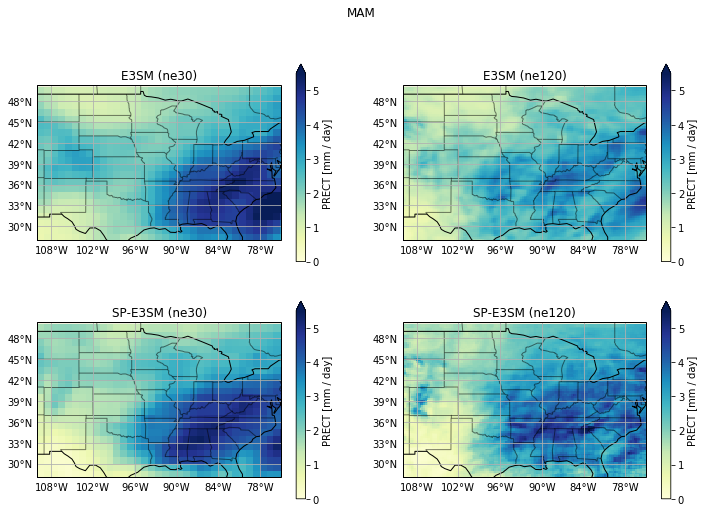

In [55]:
plot_precip_map_old(prect_seas_ne30, prect_seas_ne120,
                prect_seas_sp_ne30, prect_seas_sp_ne120,
                season='MAM', figsize=(12, 8), vmin=0, vmax=5.5)